In [27]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
# Load csv
df = pd.read_csv('/content/preprocessed_CAC40.csv', parse_dates=['Date'])

In [8]:
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [9]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)
START_DATE_TEST = END_DATE

In [10]:
data = df.copy()
data = data.loc[data.Name == COMPANY, :]
data = data.loc[(data['Date'] > START_DATE) & (data['Date'] < END_DATE), :]
data = data.rename(columns = {'Closing_Price': 'Close'})


In [11]:
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [15]:
scaled_data

array([[0.6435347 ],
       [0.64852721],
       [0.64303545],
       ...,
       [0.27608587],
       [0.31203195],
       [0.31752371]])

In [17]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from keras.callbacks import ModelCheckpoint

# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.keras',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.1000
Epoch 2/25


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0114
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0082
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0084
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0081
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0076
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0086
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0076
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0075
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0071
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0068
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0064
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0064
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0063
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0063
Epoch 16/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0060
Epoch 17/25
38

In [22]:
test_data = df.copy()
test_data = test_data.loc[test_data.Name == COMPANY, :]
test_data = test_data.loc[(test_data['Date'] > START_DATE_TEST) & (test_data['Date'] < dt.datetime.now()), :]
test_data = test_data.rename(columns = {'Closing_Price': 'Close'})

actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

model_inputs = model_inputs.reshape(-1, 1)

model_inputs = scaler.transform(model_inputs)

In [24]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


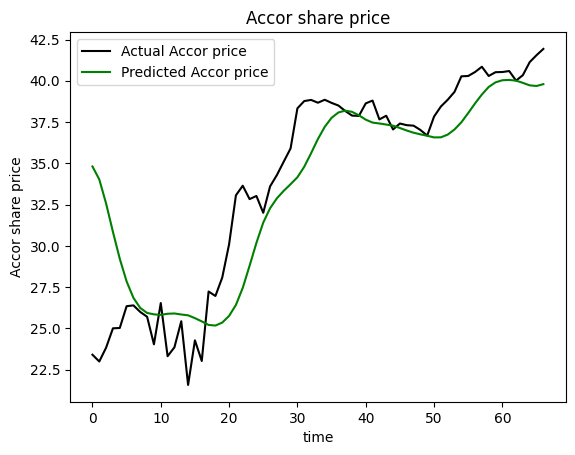

In [28]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

plt.title(f"{COMPANY} share price")

plt.xlabel("time")

plt.ylabel(f"{COMPANY} share price")

plt.legend()

plt.show()

In [29]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

real_data = np.array(real_data)

real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)

prediction = scaler.inverse_transform(prediction)

print(f"Prediction: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Prediction: 40.04806900024414
